<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Generative adversarial networks


В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения

In [198]:
DATA_DIR = 'E:/faces_dataset_small'

In [199]:
def get_dataloader(image_size, batch_size, data_dir=DATA_DIR):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """
    # TODO: resize images, convert them to tensors and build dataloader
    ds = ImageFolder(data_dir, transform=tt.Compose([tt.Resize(image_size), tt.ToTensor()]))
    return DataLoader(ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [200]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [201]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

dl = get_dataloader(image_size, batch_size=batch_size)

In [202]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [203]:
dl = DeviceDataLoader(dl, device)

In [204]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    images = images.cpu()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

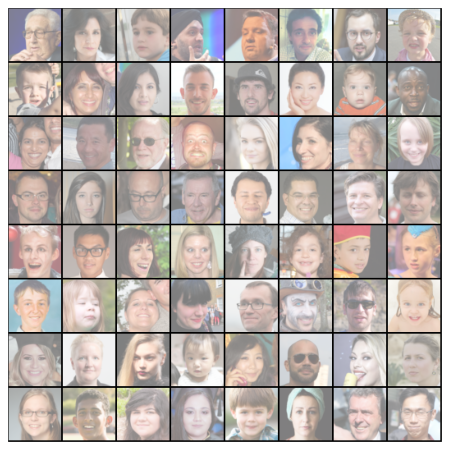

In [205]:
show_batch(dl)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [206]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [207]:
latent_size = 128

In [208]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [209]:
discriminator = to_device(discriminator, device)
generator = to_device(generator, device)

torch.Size([128, 3, 64, 64])


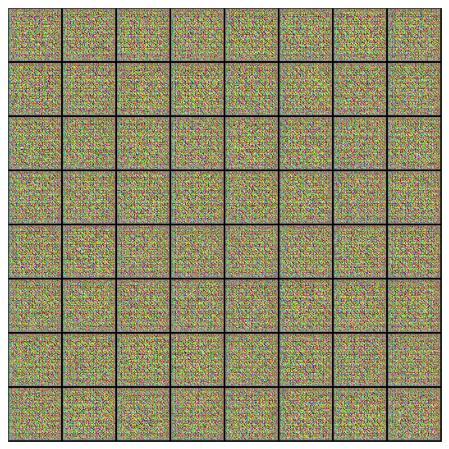

In [210]:
xb = torch.randn(batch_size, latent_size, 1, 1).to(device)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [211]:
lr = 0.0002
epochs = 200

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [213]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
    return losses_g, losses_d, real_scores, fake_scores

In [214]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/200], loss_g: 8.0102, loss_d: 0.2446, real_score: 0.9297, fake_score: 0.1227


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/200], loss_g: 15.1163, loss_d: 0.1251, real_score: 0.9818, fake_score: 0.0705


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/200], loss_g: 17.3068, loss_d: 0.2092, real_score: 0.9720, fake_score: 0.0652


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/200], loss_g: 10.2045, loss_d: 0.0674, real_score: 0.9835, fake_score: 0.0405


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/200], loss_g: 7.1831, loss_d: 0.5965, real_score: 0.8785, fake_score: 0.1434


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6/200], loss_g: 7.8882, loss_d: 0.1990, real_score: 0.9272, fake_score: 0.0725


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7/200], loss_g: 6.4125, loss_d: 0.0661, real_score: 0.9737, fake_score: 0.0331


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [8/200], loss_g: 7.6384, loss_d: 1.1172, real_score: 0.8660, fake_score: 0.0873


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [9/200], loss_g: 6.0052, loss_d: 0.2192, real_score: 0.9199, fake_score: 0.0934


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [10/200], loss_g: 6.6229, loss_d: 0.1217, real_score: 0.9571, fake_score: 0.0471


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [11/200], loss_g: 5.4877, loss_d: 0.0574, real_score: 0.9738, fake_score: 0.0265


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [12/200], loss_g: 5.5466, loss_d: 0.4964, real_score: 0.8851, fake_score: 0.1158


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [13/200], loss_g: 4.5029, loss_d: 0.7633, real_score: 0.8037, fake_score: 0.1997


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [14/200], loss_g: 4.1592, loss_d: 0.6299, real_score: 0.8036, fake_score: 0.1659


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [15/200], loss_g: 4.3799, loss_d: 0.6383, real_score: 0.8336, fake_score: 0.1810


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [16/200], loss_g: 3.8796, loss_d: 0.3935, real_score: 0.8475, fake_score: 0.1432


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [17/200], loss_g: 3.8901, loss_d: 0.6546, real_score: 0.8016, fake_score: 0.1904


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [18/200], loss_g: 3.9977, loss_d: 0.6804, real_score: 0.8023, fake_score: 0.1808


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [19/200], loss_g: 4.2428, loss_d: 0.4934, real_score: 0.8507, fake_score: 0.1563


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [20/200], loss_g: 4.2725, loss_d: 0.1885, real_score: 0.9239, fake_score: 0.0854


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [21/200], loss_g: 4.2268, loss_d: 1.1460, real_score: 0.7689, fake_score: 0.2093


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [22/200], loss_g: 3.7548, loss_d: 0.5334, real_score: 0.8357, fake_score: 0.1743


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [23/200], loss_g: 4.0066, loss_d: 0.6090, real_score: 0.7903, fake_score: 0.1910


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [24/200], loss_g: 4.4799, loss_d: 0.5368, real_score: 0.8587, fake_score: 0.1536


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [25/200], loss_g: 4.6649, loss_d: 0.5364, real_score: 0.8546, fake_score: 0.1426


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [26/200], loss_g: 4.3490, loss_d: 0.7129, real_score: 0.8031, fake_score: 0.1854


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [27/200], loss_g: 4.0569, loss_d: 0.4913, real_score: 0.8492, fake_score: 0.1594


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [28/200], loss_g: 3.7966, loss_d: 0.4916, real_score: 0.8506, fake_score: 0.1633


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [29/200], loss_g: 4.2000, loss_d: 0.4568, real_score: 0.8454, fake_score: 0.1623


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [30/200], loss_g: 4.2581, loss_d: 0.7068, real_score: 0.8020, fake_score: 0.1720


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [31/200], loss_g: 4.0563, loss_d: 0.2969, real_score: 0.8794, fake_score: 0.1260


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [32/200], loss_g: 4.9487, loss_d: 0.5972, real_score: 0.8287, fake_score: 0.1680


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [33/200], loss_g: 4.8066, loss_d: 0.5481, real_score: 0.8261, fake_score: 0.1729


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [34/200], loss_g: 4.5111, loss_d: 0.5119, real_score: 0.8301, fake_score: 0.1736


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [35/200], loss_g: 4.1091, loss_d: 0.8687, real_score: 0.7774, fake_score: 0.2062


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [36/200], loss_g: 4.2177, loss_d: 0.5620, real_score: 0.8002, fake_score: 0.1889


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [37/200], loss_g: 4.4630, loss_d: 0.4259, real_score: 0.8648, fake_score: 0.1520


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [38/200], loss_g: 4.1779, loss_d: 0.9152, real_score: 0.7723, fake_score: 0.2198


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [39/200], loss_g: 4.3744, loss_d: 0.4305, real_score: 0.8434, fake_score: 0.1656


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [40/200], loss_g: 4.4359, loss_d: 0.5602, real_score: 0.8198, fake_score: 0.1820


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [41/200], loss_g: 4.6963, loss_d: 0.6342, real_score: 0.8046, fake_score: 0.1728


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [42/200], loss_g: 4.4183, loss_d: 0.4902, real_score: 0.8327, fake_score: 0.1579


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [43/200], loss_g: 4.1267, loss_d: 0.5556, real_score: 0.8236, fake_score: 0.1882


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [44/200], loss_g: 4.2636, loss_d: 0.4846, real_score: 0.8293, fake_score: 0.1575


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [45/200], loss_g: 4.2537, loss_d: 0.5116, real_score: 0.8329, fake_score: 0.1799


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [46/200], loss_g: 4.5064, loss_d: 0.8517, real_score: 0.8216, fake_score: 0.1596


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [47/200], loss_g: 3.3670, loss_d: 0.4639, real_score: 0.8156, fake_score: 0.1834


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [48/200], loss_g: 3.9477, loss_d: 0.4286, real_score: 0.8532, fake_score: 0.1564


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [49/200], loss_g: 4.7001, loss_d: 0.5020, real_score: 0.8529, fake_score: 0.1327


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [50/200], loss_g: 4.0390, loss_d: 0.6477, real_score: 0.8163, fake_score: 0.1838


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [51/200], loss_g: 3.9259, loss_d: 0.4489, real_score: 0.8388, fake_score: 0.1614


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [52/200], loss_g: 3.9079, loss_d: 0.5396, real_score: 0.8238, fake_score: 0.1835


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [53/200], loss_g: 4.2218, loss_d: 0.5964, real_score: 0.8211, fake_score: 0.1845


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [54/200], loss_g: 3.7749, loss_d: 0.6370, real_score: 0.7994, fake_score: 0.1916


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [55/200], loss_g: 4.1468, loss_d: 0.6489, real_score: 0.8015, fake_score: 0.1837


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [56/200], loss_g: 3.8914, loss_d: 0.4728, real_score: 0.8372, fake_score: 0.1663


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [57/200], loss_g: 3.8756, loss_d: 0.4379, real_score: 0.8367, fake_score: 0.1448


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [58/200], loss_g: 3.9938, loss_d: 0.3729, real_score: 0.8682, fake_score: 0.1400


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [59/200], loss_g: 4.0277, loss_d: 0.8133, real_score: 0.8001, fake_score: 0.1915


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [60/200], loss_g: 3.6479, loss_d: 0.6036, real_score: 0.7906, fake_score: 0.1985


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [61/200], loss_g: 3.5608, loss_d: 0.3639, real_score: 0.8562, fake_score: 0.1368


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [62/200], loss_g: 4.1491, loss_d: 0.5180, real_score: 0.8342, fake_score: 0.1824


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [63/200], loss_g: 3.9817, loss_d: 0.4599, real_score: 0.8477, fake_score: 0.1488


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [64/200], loss_g: 4.0074, loss_d: 0.6482, real_score: 0.8419, fake_score: 0.1511


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [65/200], loss_g: 3.8426, loss_d: 0.4896, real_score: 0.8442, fake_score: 0.1635


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [66/200], loss_g: 3.9344, loss_d: 0.5701, real_score: 0.8129, fake_score: 0.1766


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [67/200], loss_g: 3.6682, loss_d: 0.4493, real_score: 0.8482, fake_score: 0.1391


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [68/200], loss_g: 3.5791, loss_d: 0.3932, real_score: 0.8605, fake_score: 0.1476


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [69/200], loss_g: 4.2564, loss_d: 0.5128, real_score: 0.8501, fake_score: 0.1479


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [70/200], loss_g: 3.7429, loss_d: 0.5938, real_score: 0.8324, fake_score: 0.1751


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [71/200], loss_g: 3.4849, loss_d: 0.4774, real_score: 0.8265, fake_score: 0.1870


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [72/200], loss_g: 3.6152, loss_d: 0.4530, real_score: 0.8342, fake_score: 0.1423


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [73/200], loss_g: 3.9935, loss_d: 0.4460, real_score: 0.8429, fake_score: 0.1483


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [74/200], loss_g: 4.0320, loss_d: 0.6822, real_score: 0.8040, fake_score: 0.1941


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [75/200], loss_g: 3.5069, loss_d: 0.4180, real_score: 0.8465, fake_score: 0.1543


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [76/200], loss_g: 3.8020, loss_d: 0.2542, real_score: 0.8996, fake_score: 0.1089


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [77/200], loss_g: 3.9687, loss_d: 0.5324, real_score: 0.8448, fake_score: 0.1497


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [78/200], loss_g: 4.0334, loss_d: 0.7855, real_score: 0.7850, fake_score: 0.2097


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [79/200], loss_g: 3.3862, loss_d: 0.4039, real_score: 0.8493, fake_score: 0.1558


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [80/200], loss_g: 3.7832, loss_d: 0.2606, real_score: 0.8888, fake_score: 0.1014


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [81/200], loss_g: 4.1457, loss_d: 0.5523, real_score: 0.8476, fake_score: 0.1614


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [82/200], loss_g: 3.5662, loss_d: 0.6641, real_score: 0.8018, fake_score: 0.1872


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [83/200], loss_g: 3.7049, loss_d: 0.2610, real_score: 0.8948, fake_score: 0.1103


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [84/200], loss_g: 4.3890, loss_d: 0.4811, real_score: 0.8522, fake_score: 0.1280


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [85/200], loss_g: 3.7827, loss_d: 0.3891, real_score: 0.8740, fake_score: 0.1523


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [86/200], loss_g: 3.8592, loss_d: 0.4772, real_score: 0.8356, fake_score: 0.1495


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [87/200], loss_g: 3.5485, loss_d: 0.2207, real_score: 0.9029, fake_score: 0.0994


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [88/200], loss_g: 4.3941, loss_d: 0.2049, real_score: 0.9154, fake_score: 0.0821


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [89/200], loss_g: 4.0916, loss_d: 0.5846, real_score: 0.8299, fake_score: 0.1731


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [90/200], loss_g: 4.2513, loss_d: 0.3798, real_score: 0.8628, fake_score: 0.1299


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [91/200], loss_g: 4.1099, loss_d: 0.3176, real_score: 0.8859, fake_score: 0.1252


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [92/200], loss_g: 4.3173, loss_d: 0.5065, real_score: 0.8288, fake_score: 0.1472


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [93/200], loss_g: 4.0899, loss_d: 0.6339, real_score: 0.8178, fake_score: 0.1839


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [94/200], loss_g: 3.8616, loss_d: 0.2510, real_score: 0.9000, fake_score: 0.1128


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [95/200], loss_g: 4.0982, loss_d: 0.1694, real_score: 0.9208, fake_score: 0.0716


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [96/200], loss_g: 4.3658, loss_d: 0.4527, real_score: 0.8595, fake_score: 0.1560


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [97/200], loss_g: 4.4930, loss_d: 0.2939, real_score: 0.8835, fake_score: 0.1013


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [98/200], loss_g: 4.0226, loss_d: 0.4145, real_score: 0.8645, fake_score: 0.1348


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [99/200], loss_g: 4.0744, loss_d: 0.1800, real_score: 0.9211, fake_score: 0.0800


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [100/200], loss_g: 4.4725, loss_d: 0.1323, real_score: 0.9433, fake_score: 0.0618


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [101/200], loss_g: 3.7150, loss_d: 0.7546, real_score: 0.7856, fake_score: 0.2082


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [102/200], loss_g: 4.2401, loss_d: 0.2114, real_score: 0.9092, fake_score: 0.0897


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [103/200], loss_g: 4.5523, loss_d: 0.3711, real_score: 0.8952, fake_score: 0.1095


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [104/200], loss_g: 4.3030, loss_d: 0.5492, real_score: 0.8272, fake_score: 0.1644


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [105/200], loss_g: 4.0545, loss_d: 0.2203, real_score: 0.9036, fake_score: 0.0913


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [106/200], loss_g: 4.5193, loss_d: 0.1951, real_score: 0.9260, fake_score: 0.0851


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [107/200], loss_g: 4.5604, loss_d: 0.4951, real_score: 0.8369, fake_score: 0.1476


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [108/200], loss_g: 4.2432, loss_d: 0.1680, real_score: 0.9254, fake_score: 0.0757


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [109/200], loss_g: 4.7309, loss_d: 0.3664, real_score: 0.8931, fake_score: 0.1027


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [110/200], loss_g: 4.9114, loss_d: 0.3079, real_score: 0.8909, fake_score: 0.1153


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [111/200], loss_g: 4.7703, loss_d: 0.4614, real_score: 0.8660, fake_score: 0.1194


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [112/200], loss_g: 4.2602, loss_d: 0.3659, real_score: 0.8674, fake_score: 0.1285


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [113/200], loss_g: 4.2599, loss_d: 0.2538, real_score: 0.9097, fake_score: 0.1072


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [114/200], loss_g: 4.7679, loss_d: 0.3567, real_score: 0.8865, fake_score: 0.1095


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [115/200], loss_g: 4.3253, loss_d: 0.1739, real_score: 0.9238, fake_score: 0.0768


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [116/200], loss_g: 4.6162, loss_d: 0.1435, real_score: 0.9381, fake_score: 0.0621


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [117/200], loss_g: 5.0154, loss_d: 0.3993, real_score: 0.8861, fake_score: 0.1058


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [118/200], loss_g: 4.7929, loss_d: 0.3030, real_score: 0.9032, fake_score: 0.1139


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [119/200], loss_g: 5.0744, loss_d: 0.2432, real_score: 0.9023, fake_score: 0.0890


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [120/200], loss_g: 4.4946, loss_d: 0.5406, real_score: 0.8472, fake_score: 0.1444


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [121/200], loss_g: 4.1555, loss_d: 0.2100, real_score: 0.9109, fake_score: 0.0913


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [122/200], loss_g: 4.1543, loss_d: 0.1434, real_score: 0.9357, fake_score: 0.0646


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [123/200], loss_g: 4.3275, loss_d: 0.1396, real_score: 0.9402, fake_score: 0.0620


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [124/200], loss_g: 5.0767, loss_d: 0.1859, real_score: 0.9282, fake_score: 0.0763


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [125/200], loss_g: 4.9911, loss_d: 0.2646, real_score: 0.8946, fake_score: 0.0928


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [126/200], loss_g: 4.9464, loss_d: 0.2050, real_score: 0.9233, fake_score: 0.0786


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [127/200], loss_g: 4.4341, loss_d: 0.1195, real_score: 0.9465, fake_score: 0.0544


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [128/200], loss_g: 5.2021, loss_d: 0.7055, real_score: 0.8694, fake_score: 0.1302


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [129/200], loss_g: 4.6576, loss_d: 0.3117, real_score: 0.8745, fake_score: 0.1233


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [130/200], loss_g: 4.9842, loss_d: 0.3823, real_score: 0.8697, fake_score: 0.1309


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [131/200], loss_g: 4.2790, loss_d: 0.1708, real_score: 0.9239, fake_score: 0.0760


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [132/200], loss_g: 4.3942, loss_d: 0.1632, real_score: 0.9295, fake_score: 0.0663


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [133/200], loss_g: 4.3864, loss_d: 0.1087, real_score: 0.9505, fake_score: 0.0512


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [134/200], loss_g: 5.0026, loss_d: 0.3637, real_score: 0.9058, fake_score: 0.0700


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [135/200], loss_g: 4.6834, loss_d: 0.2808, real_score: 0.9134, fake_score: 0.1054


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [136/200], loss_g: 4.3964, loss_d: 0.1233, real_score: 0.9452, fake_score: 0.0588


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [137/200], loss_g: 4.7854, loss_d: 0.3585, real_score: 0.8922, fake_score: 0.0778


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [138/200], loss_g: 4.7639, loss_d: 0.4236, real_score: 0.8875, fake_score: 0.1436


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [139/200], loss_g: 4.5548, loss_d: 0.1358, real_score: 0.9371, fake_score: 0.0601


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [140/200], loss_g: 5.0214, loss_d: 0.1871, real_score: 0.9212, fake_score: 0.0727


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [141/200], loss_g: 4.6699, loss_d: 0.1091, real_score: 0.9509, fake_score: 0.0504


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [142/200], loss_g: 4.9311, loss_d: 0.1299, real_score: 0.9453, fake_score: 0.0587


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [143/200], loss_g: 4.7977, loss_d: 0.0955, real_score: 0.9547, fake_score: 0.0437


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [144/200], loss_g: 5.0940, loss_d: 0.4837, real_score: 0.8810, fake_score: 0.1161


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [145/200], loss_g: 4.6197, loss_d: 0.1418, real_score: 0.9383, fake_score: 0.0636


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [146/200], loss_g: 4.8823, loss_d: 0.6090, real_score: 0.8578, fake_score: 0.1367


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [147/200], loss_g: 4.4429, loss_d: 0.1751, real_score: 0.9242, fake_score: 0.0788


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [148/200], loss_g: 4.7574, loss_d: 0.1320, real_score: 0.9408, fake_score: 0.0594


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [149/200], loss_g: 5.1193, loss_d: 0.6599, real_score: 0.8716, fake_score: 0.1328


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [150/200], loss_g: 4.8515, loss_d: 0.4277, real_score: 0.8515, fake_score: 0.1507


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [151/200], loss_g: 4.7858, loss_d: 0.5357, real_score: 0.8703, fake_score: 0.1157


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [152/200], loss_g: 4.2443, loss_d: 0.2174, real_score: 0.9116, fake_score: 0.0978


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [153/200], loss_g: 4.5742, loss_d: 0.1847, real_score: 0.9220, fake_score: 0.0763


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [154/200], loss_g: 4.2701, loss_d: 0.1029, real_score: 0.9523, fake_score: 0.0483


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [155/200], loss_g: 4.2906, loss_d: 0.1038, real_score: 0.9521, fake_score: 0.0481


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [156/200], loss_g: 4.7999, loss_d: 0.1767, real_score: 0.9270, fake_score: 0.0651


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [157/200], loss_g: 4.7556, loss_d: 0.1122, real_score: 0.9503, fake_score: 0.0525


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [158/200], loss_g: 4.6927, loss_d: 0.0830, real_score: 0.9622, fake_score: 0.0403


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [159/200], loss_g: 4.6452, loss_d: 0.0889, real_score: 0.9562, fake_score: 0.0390


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [160/200], loss_g: 5.8394, loss_d: 1.1423, real_score: 0.7518, fake_score: 0.2356


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [161/200], loss_g: 4.8868, loss_d: 0.2466, real_score: 0.9048, fake_score: 0.1050


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [162/200], loss_g: 4.7911, loss_d: 0.1829, real_score: 0.9239, fake_score: 0.0796


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [163/200], loss_g: 4.4932, loss_d: 0.1610, real_score: 0.9299, fake_score: 0.0671


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [164/200], loss_g: 4.6906, loss_d: 0.1747, real_score: 0.9313, fake_score: 0.0707


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [165/200], loss_g: 4.4194, loss_d: 0.1112, real_score: 0.9482, fake_score: 0.0502


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [166/200], loss_g: 5.3736, loss_d: 0.5489, real_score: 0.8613, fake_score: 0.1402


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [167/200], loss_g: 4.7504, loss_d: 0.1989, real_score: 0.9166, fake_score: 0.0818


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [168/200], loss_g: 4.5503, loss_d: 0.1425, real_score: 0.9396, fake_score: 0.0634


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [169/200], loss_g: 4.6876, loss_d: 0.1093, real_score: 0.9477, fake_score: 0.0469


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [170/200], loss_g: 4.6183, loss_d: 0.0957, real_score: 0.9566, fake_score: 0.0449


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [171/200], loss_g: 4.6270, loss_d: 0.0900, real_score: 0.9581, fake_score: 0.0421


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [172/200], loss_g: 4.8276, loss_d: 0.4209, real_score: 0.9088, fake_score: 0.0666


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [173/200], loss_g: 5.3051, loss_d: 0.4010, real_score: 0.8808, fake_score: 0.1349


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [174/200], loss_g: 5.1321, loss_d: 0.1542, real_score: 0.9381, fake_score: 0.0685


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [175/200], loss_g: 4.5894, loss_d: 0.1060, real_score: 0.9514, fake_score: 0.0488


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [176/200], loss_g: 4.5420, loss_d: 0.0905, real_score: 0.9542, fake_score: 0.0370


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [177/200], loss_g: 4.8133, loss_d: 0.9084, real_score: 0.8080, fake_score: 0.2031


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [178/200], loss_g: 6.0197, loss_d: 0.6247, real_score: 0.8328, fake_score: 0.1652


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [179/200], loss_g: 4.6549, loss_d: 0.1674, real_score: 0.9257, fake_score: 0.0711


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [180/200], loss_g: 4.7507, loss_d: 0.1478, real_score: 0.9354, fake_score: 0.0638


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [181/200], loss_g: 4.2992, loss_d: 0.0986, real_score: 0.9544, fake_score: 0.0463


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [182/200], loss_g: 4.4280, loss_d: 0.0987, real_score: 0.9539, fake_score: 0.0453


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [183/200], loss_g: 4.3875, loss_d: 0.0918, real_score: 0.9563, fake_score: 0.0422


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [184/200], loss_g: 4.8769, loss_d: 0.7124, real_score: 0.8576, fake_score: 0.1329


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [185/200], loss_g: 4.8506, loss_d: 0.2702, real_score: 0.8973, fake_score: 0.1042


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [186/200], loss_g: 4.8577, loss_d: 0.1794, real_score: 0.9279, fake_score: 0.0746


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [187/200], loss_g: 4.6291, loss_d: 0.1208, real_score: 0.9484, fake_score: 0.0573


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [188/200], loss_g: 4.2714, loss_d: 0.0920, real_score: 0.9548, fake_score: 0.0408


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [189/200], loss_g: 4.5875, loss_d: 0.0750, real_score: 0.9650, fake_score: 0.0358


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [190/200], loss_g: 4.8125, loss_d: 0.0836, real_score: 0.9593, fake_score: 0.0370


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [191/200], loss_g: 4.8334, loss_d: 0.0751, real_score: 0.9653, fake_score: 0.0357


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [192/200], loss_g: 4.7514, loss_d: 1.0549, real_score: 0.7966, fake_score: 0.1880


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [193/200], loss_g: 4.4190, loss_d: 0.3146, real_score: 0.8825, fake_score: 0.1304


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [194/200], loss_g: 4.9575, loss_d: 0.1571, real_score: 0.9339, fake_score: 0.0702


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [195/200], loss_g: 5.6649, loss_d: 0.4710, real_score: 0.8620, fake_score: 0.1326


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [196/200], loss_g: 4.8508, loss_d: 0.1344, real_score: 0.9419, fake_score: 0.0608


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [197/200], loss_g: 4.8245, loss_d: 0.1307, real_score: 0.9441, fake_score: 0.0578


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [198/200], loss_g: 4.4805, loss_d: 0.0899, real_score: 0.9577, fake_score: 0.0417


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [199/200], loss_g: 4.6979, loss_d: 0.0959, real_score: 0.9556, fake_score: 0.0426


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [200/200], loss_g: 4.7331, loss_d: 0.0804, real_score: 0.9620, fake_score: 0.0373


Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [215]:
losses_g, losses_d, real_scores, fake_scores = history

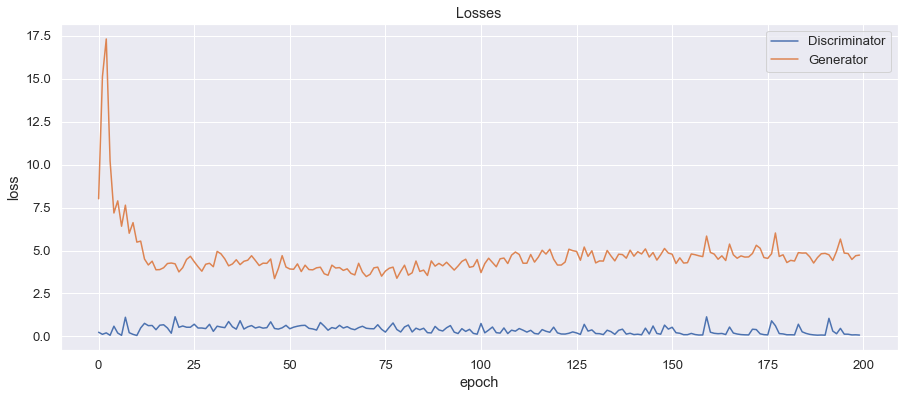

In [216]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

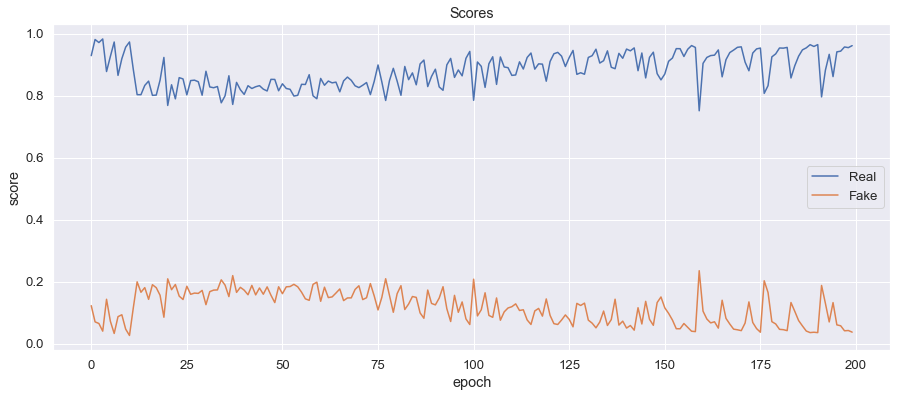

In [217]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [218]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

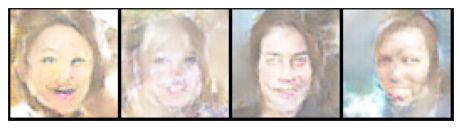

In [219]:
show_images(fake_images)

Как вам качество получившихся изображений?

Людьми это сложно назвать (много артефактов), но что-то похожее есть.

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [220]:
sample_dir = 'E:/generated/data'

In [221]:
def save_samples(n_samples):
    for i in range(n_samples):
        fixed_latent = torch.randn(1, latent_size, 1, 1, device=device)
        fake_image = generator(fixed_latent)
        fake_fname = 'generated-image-{}.png'.format(i)
        save_image(fake_image, os.path.join(sample_dir, fake_fname))

In [222]:
save_samples(3143)

In [228]:
fake_data = get_dataloader(image_size, batch_size, 'E:/generated')
fake_data = [x for x, _ in fake_dl]
fake_data = torch.vstack(fake_data).view(-1, 3*64*64).cpu().numpy()

In [229]:
real_data = [x for x, _ in dl]
real_data = torch.vstack(real_dl).view(-1, 3*64*64).cpu().numpy()

In [230]:
X = np.vstack([real_data, fake_data])
y = np.concatenate([np.ones(3143), np.zeros(3143)])

**Комментарий**. Т.к. датасет большой (6186 картинок), LeaveOneOut на всем датасете считать долго. Возьмем первые 100 записей после решафла и посчитаем acc на них.

In [232]:
per = np.random.permutation(len(y))

In [233]:
X, y = X[per], y[per]

In [234]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut

In [235]:
res = []
i = 0
for train, test in tqdm(LeaveOneOut().split(X)):
    if i > 100:
        break
    knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    knn.fit(X[train], y[train])
    p = knn.predict(X[test])
    res.append(y[test] == p)
    i += 1
    print("iter {} done".format(i))

0it [00:00, ?it/s]

iter 1 done
iter 2 done
iter 3 done
iter 4 done
iter 5 done
iter 6 done
iter 7 done
iter 8 done
iter 9 done
iter 10 done
iter 11 done
iter 12 done
iter 13 done
iter 14 done
iter 15 done
iter 16 done
iter 17 done
iter 18 done
iter 19 done
iter 20 done
iter 21 done
iter 22 done
iter 23 done
iter 24 done
iter 25 done
iter 26 done
iter 27 done
iter 28 done
iter 29 done
iter 30 done
iter 31 done
iter 32 done
iter 33 done
iter 34 done
iter 35 done
iter 36 done
iter 37 done
iter 38 done
iter 39 done
iter 40 done
iter 41 done
iter 42 done
iter 43 done
iter 44 done
iter 45 done
iter 46 done
iter 47 done
iter 48 done
iter 49 done
iter 50 done
iter 51 done
iter 52 done
iter 53 done
iter 54 done
iter 55 done
iter 56 done
iter 57 done
iter 58 done
iter 59 done
iter 60 done
iter 61 done
iter 62 done
iter 63 done
iter 64 done
iter 65 done
iter 66 done
iter 67 done
iter 68 done
iter 69 done
iter 70 done
iter 71 done
iter 72 done
iter 73 done
iter 74 done
iter 75 done
iter 76 done
iter 77 done
iter 78 

0 и 1 распределены равномерно в вычисляемом множестве.

In [247]:
np.unique(y[:101], return_counts=True)

(array([0., 1.]), array([51, 50], dtype=int64))

In [240]:
res = [x[0] for x in res]

In [244]:
print("final acc={}".format(res.count(True) / len(res)))

final acc=0.9207920792079208


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

**Комментарий.** Судя по результату, картинки генерируются достаточно непохожими на оригиналы. Считаю, что в идеале acc должно быть близка к 0.5, поскольку мы всем картинкам хотим присвоить метку 1 (половине реальных и половине сгенерированных).

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [248]:
from sklearn.manifold import TSNE
import seaborn as sns

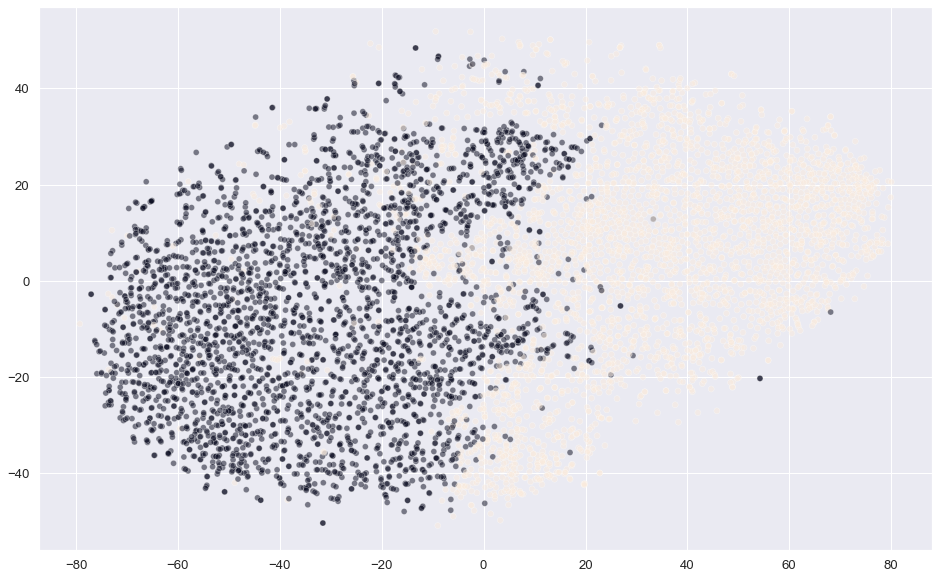

In [253]:
embeded = TSNE(n_components=2).fit_transform(X)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=embeded[:,0], 
    y=embeded[:,1],
    c = y,
    palette=[sns.color_palette("hls", 2)],
    legend="full",
    alpha=0.5
);

Прокомментируйте получившийся результат:

**Комментарий.** С распределением все не так плохо. Точки концентрируются в едином облаке, т.е. нет сильной кластеризации реальных и фейковых точек. Это говорит о том, что в целом генерируется что-то похожее на лица, а не совсем белый шум (но и не прям вточности человечекие лица, если судить по acc).